In [140]:
import pandas as pd
import numpy as np
import sqlalchemy
import seaborn as sns
from clickhouse_driver import Client
from pandas_profiling import ProfileReport
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
from plotly.subplots import make_subplots
import plotly.express as px
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import h3
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [141]:
client = Client('89.208.84.253',
                port= '59000',
                user='student',
                password='nUrHdn2N',
                secure=False,
                verify=True,
                database='data_analysis',
                compression=False)

In [142]:
result,columns = client.execute("""select *
from data_analysis.views
""",with_column_types=True)

In [143]:
views = pd.DataFrame(result, columns = [tuple[0] for tuple in columns])
dollar_rate = 75
views['client_bill_rus'] = views['client_bill_usd'] * dollar_rate
views = views.drop('client_bill_usd', axis=1)
views[['latitude','longitude', 'del_latitude','del_longitude']] = views[['latitude','longitude', 'del_latitude','del_longitude']].round(1)
views['location_start'] = views[['latitude','longitude']].values.tolist()
views['location_finish'] = views[['del_latitude','del_longitude']].values.tolist()

views.head()

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,latitude,longitude,del_latitude,del_longitude,client_bill_rus,location_start,location_finish
0,944452746,2015-12-14 19:43:26,Эконом,0,3923985705,57.6,39.9,57.6,39.8,189.00,"[57.6, 39.9]","[57.6, 39.8]"
1,1124126659,2015-12-14 19:43:28,Комфорт,0,1613934680,55.9,37.4,0.0,0.0,0.00,"[55.9, 37.4]","[0.0, 0.0]"
2,4108744040,2015-12-14 19:43:28,Эконом,0,112675651,57.7,39.8,57.7,39.9,417.75,"[57.7, 39.8]","[57.7, 39.9]"
3,2884954660,2015-12-14 19:43:29,Эконом,0,1584742787,57.6,39.9,57.6,39.8,248.25,"[57.6, 39.9]","[57.6, 39.8]"
4,3769769055,2015-12-14 19:43:30,Эконом,0,2202904080,55.8,37.6,55.8,37.7,449.25,"[55.8, 37.6]","[55.8, 37.7]"


In [144]:
result1,columns1 = client.execute("""select *
from data_analysis.orders
""",with_column_types=True)

In [145]:
orders = pd.DataFrame(result1, columns=[tuple[0] for tuple in columns1])
orders.head(3)

,idhash_order,idhash_view,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status
0,3777115420,95199865,2015-12-06 00:00:09,2015-12-06 00:00:09,2015-12-06 00:03:31,2015-12-06 00:04:59,2015-12-06 00:10:06,NaT,CP
1,2983673012,3853062057,2015-12-06 00:00:11,2015-12-06 00:00:12,NaT,NaT,NaT,2015-12-06 00:01:26,CC
2,2177076394,147233410,2015-12-06 00:00:26,2015-12-06 00:00:37,2015-12-06 00:04:31,2015-12-06 00:07:06,2015-12-06 00:12:29,NaT,CP


In [146]:
# data = orders.drop(['idhash_view'],axis = 1).join(views.set_index('idhash_order'), on='idhash_order',how = 'inner')
# data

In [147]:
views_orders = orders.drop(['idhash_view'],axis = 1).join(views.set_index('idhash_order'), on='idhash_order',how = 'inner')
# pd.merge(views, orders, how='inner', on='idhash_order')
views_orders.sort_values(by='idhash_client', ascending=True, inplace=True)

views_orders

,idhash_order,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,idhash_view,view_dttm,tariff,idhash_client,latitude,longitude,del_latitude,del_longitude,client_bill_rus,location_start,location_finish
17720,2686729818,2015-12-08 22:28:49,2015-12-08 22:46:05,2015-12-08 22:50:29,2015-12-08 23:02:07,2015-12-08 23:06:38,NaT,CP,4139885053,2015-12-08 22:28:46,Эконом,39262,57.6,39.8,57.6,39.8,139.50,"[57.6, 39.8]","[57.6, 39.8]"
42801,1339001373,2015-12-12 22:47:38,2015-12-12 22:47:45,2015-12-12 22:54:01,2015-12-12 23:02:56,2015-12-12 23:07:10,NaT,CP,3978633497,2015-12-12 22:47:35,Эконом,39262,57.6,39.8,57.6,39.8,129.00,"[57.6, 39.8]","[57.6, 39.8]"
59900,4076411177,2015-12-15 22:32:21,NaT,NaT,NaT,NaT,2015-12-15 23:02:19,CC,4241509287,2015-12-15 22:32:20,Эконом,39262,57.6,39.8,57.6,39.8,109.50,"[57.6, 39.8]","[57.6, 39.8]"
42764,790101098,2015-12-12 22:43:01,2015-12-12 22:46:09,NaT,NaT,NaT,2015-12-12 22:47:07,CC,731098178,2015-12-12 22:42:56,Эконом,39262,57.6,39.8,57.6,39.8,129.00,"[57.6, 39.8]","[57.6, 39.8]"
85682,2761390152,2015-12-19 22:42:41,2015-12-19 22:45:59,2015-12-19 22:52:06,2015-12-19 23:02:15,2015-12-19 23:05:39,NaT,CP,3709831592,2015-12-19 22:42:40,Комфорт,39262,57.6,39.8,57.6,39.8,209.25,"[57.6, 39.8]","[57.6, 39.8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46777,3146753536,2015-12-13 16:27:22,2015-12-13 16:27:35,2015-12-13 16:30:21,2015-12-13 16:36:45,2015-12-13 16:41:46,NaT,CP,2294610960,2015-12-13 16:27:19,Комфорт+,4294468826,57.6,39.9,57.6,39.9,207.00,"[57.6, 39.9]","[57.6, 39.9]"
22862,4155013083,2015-12-09 19:59:22,2015-12-09 19:59:24,NaT,NaT,NaT,2015-12-09 19:59:26,CC,4115308172,2015-12-09 19:59:19,Эконом,4294468826,57.6,39.9,57.6,39.9,131.25,"[57.6, 39.9]","[57.6, 39.9]"
48135,759999585,2015-12-13 21:48:13,2015-12-13 21:48:16,2015-12-13 21:50:33,2015-12-13 21:54:21,2015-12-13 22:09:26,NaT,CP,3143083069,2015-12-13 21:47:56,Эконом,4294468826,57.6,39.9,57.6,39.9,248.25,"[57.6, 39.9]","[57.6, 39.9]"
68718,1016393930,2015-12-17 10:52:44,2015-12-17 10:52:47,2015-12-17 10:56:29,2015-12-17 10:58:23,2015-12-17 11:01:39,NaT,CP,2241874340,2015-12-17 10:52:29,Эконом,4294468826,57.6,39.9,57.6,39.8,137.25,"[57.6, 39.9]","[57.6, 39.8]"


In [148]:
df = views_orders.groupby('idhash_client', as_index=False).agg({'client_bill_rus':'sum', 'idhash_order':'count',
                                                'order_dttm':'max', 
#                                                 'latitude':'mean','longitude':'mean',
#                                                'del_latitude':'mean', 'del_longitude': 'mean'
                                               })\
                                          .sort_values(by='idhash_client', ascending=True)
                       
df

,idhash_client,client_bill_rus,idhash_order,order_dttm
0,39262,716.250,5,2015-12-19 22:42:41
1,48902,198.750,1,2015-12-14 12:32:11
2,199395,1433.250,4,2015-12-17 10:12:34
3,420016,306.000,1,2015-12-19 22:40:34
4,1721255,897.000,3,2015-12-17 23:41:47
...,...,...,...,...
22710,4294082201,0.000,1,2015-12-07 08:47:02
22711,4294223508,1749.750,3,2015-12-16 19:31:39
22712,4294324984,453.750,2,2015-12-12 00:46:29
22713,4294468826,3748.125,16,2015-12-17 22:45:22


In [149]:
df = pd.merge(df[['idhash_client','client_bill_rus', 'idhash_order', 'order_dttm']], 
               views_orders[['view_dttm','location_start', 'order_dttm',  'location_finish', 'latitude', 'longitude',
                            'del_latitude', 'del_longitude']], how = 'inner', on='order_dttm')
df

,idhash_client,client_bill_rus,idhash_order,order_dttm,view_dttm,location_start,location_finish,latitude,longitude,del_latitude,del_longitude
0,39262,716.250,5,2015-12-19 22:42:41,2015-12-19 22:42:40,"[57.6, 39.8]","[57.6, 39.8]",57.6,39.8,57.6,39.8
1,48902,198.750,1,2015-12-14 12:32:11,2015-12-14 12:32:10,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9
2,199395,1433.250,4,2015-12-17 10:12:34,2015-12-17 10:12:33,"[57.6, 39.8]","[57.6, 39.9]",57.6,39.8,57.6,39.9
3,420016,306.000,1,2015-12-19 22:40:34,2015-12-19 22:40:29,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9
4,420016,306.000,1,2015-12-19 22:40:34,2015-12-19 22:40:20,"[57.6, 40.0]","[57.6, 39.9]",57.6,40.0,57.6,39.9
...,...,...,...,...,...,...,...,...,...,...,...
24822,4294082201,0.000,1,2015-12-07 08:47:02,2015-12-07 08:46:54,"[57.6, 39.9]","[0.0, 0.0]",57.6,39.9,0.0,0.0
24823,4294223508,1749.750,3,2015-12-16 19:31:39,2015-12-16 19:31:38,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9
24824,4294324984,453.750,2,2015-12-12 00:46:29,2015-12-12 00:46:25,"[57.7, 39.8]","[57.7, 39.8]",57.7,39.8,57.7,39.8
24825,4294468826,3748.125,16,2015-12-17 22:45:22,2015-12-17 22:45:20,"[57.6, 39.8]","[57.6, 39.9]",57.6,39.8,57.6,39.9


# Разбивка на RFM сегменты

In [150]:
now = datetime.datetime.now()
now

datetime.datetime(2021, 4, 17, 17, 34, 59, 481817)

In [151]:
df['quantile_bill_rus_33'] = np.percentile(df['client_bill_rus'], 33)
df['quantile_bill_rus_66'] = df['client_bill_rus'].quantile(.66)
df['quantile_idhash_order_33'] = df['idhash_order'].quantile(.33)
df['quantile_idhash_order_66'] = df['idhash_order'].quantile(.66)
df['diff_date'] = now - df['order_dttm']
df['diff_date'] = pd.to_numeric(df['diff_date'].dt.days, downcast='integer')
df['quantile_order_dttm_33'] = df['diff_date'].quantile(.33)
df['quantile_order_dttm_66'] = df['diff_date'].quantile(.66)
df.head(3)

,idhash_client,client_bill_rus,idhash_order,order_dttm,view_dttm,location_start,location_finish,latitude,longitude,del_latitude,del_longitude,quantile_bill_rus_33,quantile_bill_rus_66,quantile_idhash_order_33,quantile_idhash_order_66,diff_date,quantile_order_dttm_33,quantile_order_dttm_66
0,39262,716.25,5,2015-12-19 22:42:41,2015-12-19 22:42:40,"[57.6, 39.8]","[57.6, 39.8]",57.6,39.8,57.6,39.8,423.75,1058.25,1.0,3.0,1945,1948.0,1953.0
1,48902,198.75,1,2015-12-14 12:32:11,2015-12-14 12:32:10,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,423.75,1058.25,1.0,3.0,1951,1948.0,1953.0
2,199395,1433.25,4,2015-12-17 10:12:34,2015-12-17 10:12:33,"[57.6, 39.8]","[57.6, 39.9]",57.6,39.8,57.6,39.9,423.75,1058.25,1.0,3.0,1948,1948.0,1953.0


In [152]:
df.loc[(df['client_bill_rus']<df['quantile_bill_rus_33']), 'M'] = 1

In [153]:
df.loc[((df['client_bill_rus']<df['quantile_bill_rus_66']) & (df['quantile_bill_rus_33'] <= df['client_bill_rus'])),'M'] = 2

In [154]:
df.loc[(df['client_bill_rus']>df['quantile_bill_rus_66']), 'M'] = 3

In [155]:
df = df.drop(['quantile_bill_rus_33', 'quantile_bill_rus_66'], axis=1)
df

,idhash_client,client_bill_rus,idhash_order,order_dttm,view_dttm,location_start,location_finish,latitude,longitude,del_latitude,del_longitude,quantile_idhash_order_33,quantile_idhash_order_66,diff_date,quantile_order_dttm_33,quantile_order_dttm_66,M
0,39262,716.250,5,2015-12-19 22:42:41,2015-12-19 22:42:40,"[57.6, 39.8]","[57.6, 39.8]",57.6,39.8,57.6,39.8,1.0,3.0,1945,1948.0,1953.0,2.0
1,48902,198.750,1,2015-12-14 12:32:11,2015-12-14 12:32:10,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,1.0,3.0,1951,1948.0,1953.0,1.0
2,199395,1433.250,4,2015-12-17 10:12:34,2015-12-17 10:12:33,"[57.6, 39.8]","[57.6, 39.9]",57.6,39.8,57.6,39.9,1.0,3.0,1948,1948.0,1953.0,3.0
3,420016,306.000,1,2015-12-19 22:40:34,2015-12-19 22:40:29,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,1.0,3.0,1945,1948.0,1953.0,1.0
4,420016,306.000,1,2015-12-19 22:40:34,2015-12-19 22:40:20,"[57.6, 40.0]","[57.6, 39.9]",57.6,40.0,57.6,39.9,1.0,3.0,1945,1948.0,1953.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24822,4294082201,0.000,1,2015-12-07 08:47:02,2015-12-07 08:46:54,"[57.6, 39.9]","[0.0, 0.0]",57.6,39.9,0.0,0.0,1.0,3.0,1958,1948.0,1953.0,1.0
24823,4294223508,1749.750,3,2015-12-16 19:31:39,2015-12-16 19:31:38,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,1.0,3.0,1948,1948.0,1953.0,3.0
24824,4294324984,453.750,2,2015-12-12 00:46:29,2015-12-12 00:46:25,"[57.7, 39.8]","[57.7, 39.8]",57.7,39.8,57.7,39.8,1.0,3.0,1953,1948.0,1953.0,2.0
24825,4294468826,3748.125,16,2015-12-17 22:45:22,2015-12-17 22:45:20,"[57.6, 39.8]","[57.6, 39.9]",57.6,39.8,57.6,39.9,1.0,3.0,1947,1948.0,1953.0,3.0


In [156]:
df.loc[(df['idhash_order']<=df['quantile_idhash_order_33']), 'F'] = 1

In [157]:
df.loc[((df['idhash_order']<df['quantile_idhash_order_66']) & (df['quantile_idhash_order_33'] < df['idhash_order'])),'F'] = 2

In [158]:
df.loc[(df['idhash_order']>df['quantile_idhash_order_66']), 'F'] = 3

In [159]:
df = df.drop(['quantile_idhash_order_33', 'quantile_idhash_order_66'], axis=1)
df.head(5)

,idhash_client,client_bill_rus,idhash_order,order_dttm,view_dttm,location_start,location_finish,latitude,longitude,del_latitude,del_longitude,diff_date,quantile_order_dttm_33,quantile_order_dttm_66,M,F
0,39262,716.25,5,2015-12-19 22:42:41,2015-12-19 22:42:40,"[57.6, 39.8]","[57.6, 39.8]",57.6,39.8,57.6,39.8,1945,1948.0,1953.0,2.0,3.0
1,48902,198.75,1,2015-12-14 12:32:11,2015-12-14 12:32:10,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,1951,1948.0,1953.0,1.0,1.0
2,199395,1433.25,4,2015-12-17 10:12:34,2015-12-17 10:12:33,"[57.6, 39.8]","[57.6, 39.9]",57.6,39.8,57.6,39.9,1948,1948.0,1953.0,3.0,3.0
3,420016,306.00,1,2015-12-19 22:40:34,2015-12-19 22:40:29,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,1945,1948.0,1953.0,1.0,1.0
4,420016,306.00,1,2015-12-19 22:40:34,2015-12-19 22:40:20,"[57.6, 40.0]","[57.6, 39.9]",57.6,40.0,57.6,39.9,1945,1948.0,1953.0,1.0,1.0


In [160]:
df.loc[(df['diff_date']<=df['quantile_order_dttm_33']), 'R'] = 3

In [161]:
df.loc[((df['diff_date'] < df['quantile_order_dttm_66']) & (df['quantile_order_dttm_33'] < df['diff_date'])), 'R'] = 2

In [162]:
df.loc[(df['diff_date'] >= df['quantile_order_dttm_66']), 'R'] = 1

In [163]:
df = df.drop(['quantile_order_dttm_33', 'quantile_order_dttm_66'], axis=1)

In [164]:
df['RFM'] = df['R']*100 + df['F']*10 + df['M']
df.head()

,idhash_client,client_bill_rus,idhash_order,order_dttm,view_dttm,location_start,location_finish,latitude,longitude,del_latitude,del_longitude,diff_date,M,F,R,RFM
0,39262,716.25,5,2015-12-19 22:42:41,2015-12-19 22:42:40,"[57.6, 39.8]","[57.6, 39.8]",57.6,39.8,57.6,39.8,1945,2.0,3.0,3.0,332.0
1,48902,198.75,1,2015-12-14 12:32:11,2015-12-14 12:32:10,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,1951,1.0,1.0,2.0,211.0
2,199395,1433.25,4,2015-12-17 10:12:34,2015-12-17 10:12:33,"[57.6, 39.8]","[57.6, 39.9]",57.6,39.8,57.6,39.9,1948,3.0,3.0,3.0,333.0
3,420016,306.00,1,2015-12-19 22:40:34,2015-12-19 22:40:29,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,1945,1.0,1.0,3.0,311.0
4,420016,306.00,1,2015-12-19 22:40:34,2015-12-19 22:40:20,"[57.6, 40.0]","[57.6, 39.9]",57.6,40.0,57.6,39.9,1945,1.0,1.0,3.0,311.0


In [165]:
df.isnull().sum()

idhash_client         0
client_bill_rus       0
idhash_order          0
order_dttm            0
view_dttm             0
location_start        0
location_finish       0
latitude              0
longitude             0
del_latitude          0
del_longitude         0
diff_date             0
M                     4
F                  2789
R                     0
RFM                2792
dtype: int64

## Метрики с разбиением по сегментам:

In [166]:
df['hour'] = df['order_dttm'].dt.hour
df['order_dttm'] = df['order_dttm'].dt.date

<AxesSubplot:>

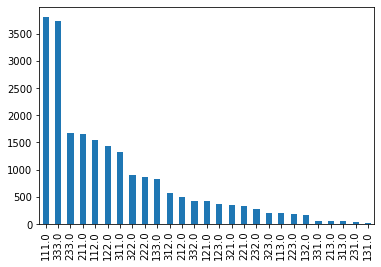

In [167]:
df['RFM'].value_counts().plot(kind='bar')

Таким образом, в первую пятерку входят клиенты: 
1) VIP 

2) Потерянные экономные

3) Спящие разовые с маленьким чеком

4) Одноразовые

5) Спящие постоянные с высоким чеком

### View2Order (orders/views) по сегментам и в динамике по дням и времени суток (разделить сутки на утро-день-вечер-ночь)

<AxesSubplot:>

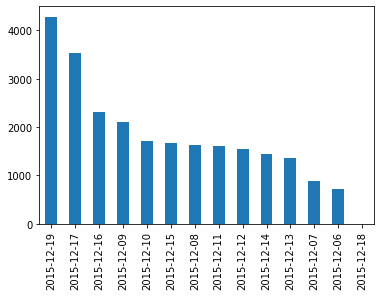

In [168]:
df['order_dttm'].value_counts().plot(kind='bar')

Можно сказать, что пользователи больше пользуются такси перед новогодними праздниками, когда нужно ездить за подарками и в гости (в целом предсказуемо:) )

In [169]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [170]:
df['day_part'] = df['hour'].apply(f)
df.head()

,idhash_client,client_bill_rus,idhash_order,order_dttm,view_dttm,location_start,location_finish,latitude,longitude,del_latitude,del_longitude,diff_date,M,F,R,RFM,hour,day_part
0,39262,716.25,5,2015-12-19,2015-12-19 22:42:40,"[57.6, 39.8]","[57.6, 39.8]",57.6,39.8,57.6,39.8,1945,2.0,3.0,3.0,332.0,22,Night
1,48902,198.75,1,2015-12-14,2015-12-14 12:32:10,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,1951,1.0,1.0,2.0,211.0,12,Morning
2,199395,1433.25,4,2015-12-17,2015-12-17 10:12:33,"[57.6, 39.8]","[57.6, 39.9]",57.6,39.8,57.6,39.9,1948,3.0,3.0,3.0,333.0,10,Morning
3,420016,306.00,1,2015-12-19,2015-12-19 22:40:29,"[57.6, 39.9]","[57.6, 39.9]",57.6,39.9,57.6,39.9,1945,1.0,1.0,3.0,311.0,22,Night
4,420016,306.00,1,2015-12-19,2015-12-19 22:40:20,"[57.6, 40.0]","[57.6, 39.9]",57.6,40.0,57.6,39.9,1945,1.0,1.0,3.0,311.0,22,Night


<AxesSubplot:>

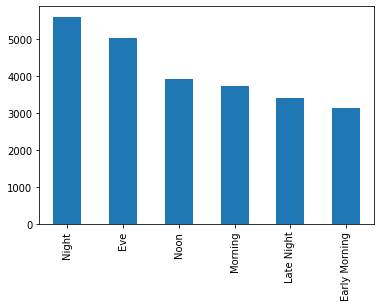

In [171]:
df['day_part'].value_counts().plot(kind='bar')

Пользователи больше берут такси с 20 до 24 часов

 ### Средний чек в разбивке по сегментам

In [172]:
df.groupby('RFM').agg({'client_bill_rus': 'mean'}).sort_values(by='client_bill_rus', ascending=False)

,client_bill_rus
RFM,
333.0,3158.512048
213.0,2690.772321
313.0,2414.319444
233.0,2410.868962
133.0,2269.992780
113.0,2143.966463
123.0,1758.927898
223.0,1612.783163
323.0,1599.182039


In [173]:
import requests
session = requests.Session()
session.headers.update({'User-Agent': 'den'})
session.get('https://httpbin.org/headers').text
geolocator = Nominatim(user_agent="den")

def get_city(locations):
    cities = []
    for location in locations:
        cities.append(geolocator.reverse(location).raw['address'].get('city'))
    return cities

In [174]:
t = df.groupby(['latitude','longitude'], as_index=False).agg({'client_bill_rus': 'mean'})
t

,latitude,longitude,client_bill_rus
0,55.6,40.6,297.625000
1,55.6,40.7,839.250000
2,55.9,40.3,6017.625000
3,55.9,40.6,946.500000
4,55.9,40.8,710.625000
...,...,...,...
149,59.1,37.9,333.750000
150,59.1,38.0,0.000000
151,59.2,39.8,940.437500
152,59.2,39.9,854.208333


In [175]:
t['location_start'] = t[['latitude', 'longitude']].values.tolist()

In [176]:
t['city'] = get_city(t['location_start'])
t.sort_values(by='client_bill_rus', ascending=True, inplace=True)

### Средний чек в разбивке по городам

In [177]:
t1 = t.groupby(['city'], as_index=False).agg({'client_bill_rus': 'mean'})
t1['mean_bill'] = t1['client_bill_rus']
t1.sort_values(by='client_bill_rus', ascending=False, inplace=True)
t1

,city,client_bill_rus,mean_bill
6,Ярославль,1146.827288,1146.827288
1,Вологда,897.322917,897.322917
2,Иваново,703.510417,703.510417
3,Кострома,672.026786,672.026786
4,Рыбинск,431.750000,431.750000
0,Владимир,372.552632,372.552632
5,Череповец,166.875000,166.875000


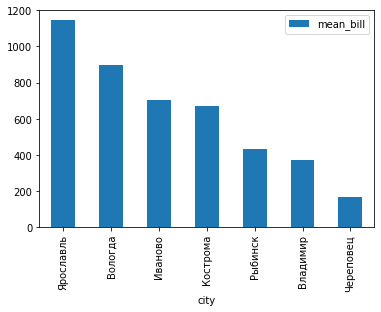

In [178]:
t1.plot(x="city", y="mean_bill", kind='bar', rot=90)
plt.xticks()
plt.show()

### IQR по клиентскому чеку в разбивке по городу и сегменту.

In [179]:
t['client_bill_rus_25_percen'] = np.percentile(t['client_bill_rus'], 25)

In [180]:
t['client_bill_rus_75_percen'] = np.percentile(t['client_bill_rus'], 75)

In [181]:
t['IQR_bill'] = t['client_bill_rus_75_percen'] - t['client_bill_rus_25_percen']

In [182]:
# IQR по клиентскому чеку в разбивке по городу
t['IQR_bill'][0]

1154.566006097561

In [183]:
rfm = df.groupby('RFM', as_index=False).agg({'client_bill_rus':'mean'})

In [184]:
rfm['client_bill_rus_25_percen'] = np.percentile(rfm['client_bill_rus'], 25)

In [185]:
rfm['client_bill_rus_75_percen'] = np.percentile(rfm['client_bill_rus'], 75)

In [186]:
rfm['IQR_bill'] = rfm['client_bill_rus_75_percen'] - rfm['client_bill_rus_25_percen']

In [187]:
# IQR по клиентскому чеку в разбивке по сегментам
rfm['IQR_bill'][0]

1405.3392463379187

## Метрики без разбиения по сегментам:

### Cредняяя длительность поездок по часам

In [206]:
orders['diff_cc_finsh'] = orders['finish_dttm'] - orders['cc_dttm']
orders['diff_cc_finsh'] = orders['diff_cc_finsh'].astype('timedelta64[h]')

In [207]:
orders.head(15)

,idhash_order,idhash_view,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,hour_cc_dttm,hour_finish_dttm,diff_cc_finsh
0,3777115420,95199865,2015-12-06 00:00:09,2015-12-06 00:00:09,2015-12-06 00:03:31,2015-12-06 00:04:59,2015-12-06 00:10:06,NaT,CP,0.0,0.0,0.0
1,2983673012,3853062057,2015-12-06 00:00:11,2015-12-06 00:00:12,NaT,NaT,NaT,2015-12-06 00:01:26,CC,NaN,NaN,NaN
2,2177076394,147233410,2015-12-06 00:00:26,2015-12-06 00:00:37,2015-12-06 00:04:31,2015-12-06 00:07:06,2015-12-06 00:12:29,NaT,CP,0.0,0.0,0.0
3,1997846256,518227239,2015-12-06 00:00:32,2015-12-06 00:00:41,2015-12-06 00:04:04,2015-12-06 00:06:08,2015-12-06 00:17:11,NaT,CP,0.0,0.0,0.0
4,1893504594,3623774808,2015-12-06 00:01:07,2015-12-06 00:04:46,2015-12-06 00:11:35,2015-12-06 00:13:01,2015-12-06 00:29:43,NaT,CP,0.0,0.0,0.0
5,3136231244,1129037615,2015-12-06 00:01:08,2015-12-06 00:01:20,NaT,NaT,NaT,2015-12-06 00:02:32,CC,NaN,NaN,NaN
6,2781691252,2348665285,2015-12-06 00:02:01,NaT,NaT,NaT,NaT,2015-12-06 00:04:57,CC,NaN,NaN,NaN
7,1626214299,2013690030,2015-12-06 00:02:02,2015-12-06 00:03:30,NaT,NaT,NaT,2015-12-06 00:05:08,CC,NaN,NaN,NaN
8,75680415,1144749526,2015-12-06 00:02:06,NaT,NaT,NaT,NaT,2015-12-06 00:02:32,CC,NaN,NaN,NaN
9,1786344293,545184141,2015-12-06 00:02:09,2015-12-06 00:02:10,2015-12-06 00:07:56,2015-12-06 00:08:06,2015-12-06 00:18:00,NaT,CP,0.0,0.0,0.0


In [208]:
order_diff = orders.groupby('idhash_order', as_index=False).agg({'diff_cc_finsh':'mean'})
order_diff

,idhash_order,diff_cc_finsh
0,102020,0.0
1,140087,0.0
2,268731,0.0
3,315231,0.0
4,331466,0.0
...,...,...
86118,4294704551,0.0
86119,4294766618,NaN
86120,4294897767,0.0
86121,4294942694,NaN


In [209]:
order_diff1 = order_diff.groupby('diff_cc_finsh', as_index=False).agg({'idhash_order':'count'})
order_diff1

,diff_cc_finsh,idhash_order
0,0.0,54856
1,1.0,113
2,2.0,17
3,3.0,2
4,4.0,6
5,5.0,1
6,6.0,1
7,7.0,1
8,9.0,1
9,10.0,1


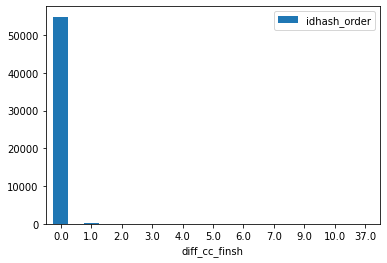

In [572]:
order_diff1.plot(x='diff_cc_finsh', y="idhash_order", kind='bar', rot=0)
plt.xticks()
plt.show()

### Динамика ценообразования

In [509]:
views_orders1 = views_orders.copy()
views_orders1.head(2)

,idhash_order,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,idhash_view,view_dttm,tariff,idhash_client,latitude,longitude,del_latitude,del_longitude,client_bill_rus,location_start,location_finish
17720,2686729818,2015-12-08 22:28:49,2015-12-08 22:46:05,2015-12-08 22:50:29,2015-12-08 23:02:07,2015-12-08 23:06:38,NaT,CP,4139885053,2015-12-08 22:28:46,Эконом,39262,57.6,39.8,57.6,39.8,139.5,"[57.6, 39.8]","[57.6, 39.8]"
42801,1339001373,2015-12-12 22:47:38,2015-12-12 22:47:45,2015-12-12 22:54:01,2015-12-12 23:02:56,2015-12-12 23:07:10,NaT,CP,3978633497,2015-12-12 22:47:35,Эконом,39262,57.6,39.8,57.6,39.8,129.0,"[57.6, 39.8]","[57.6, 39.8]"


In [510]:
views_orders1.dropna(subset= ['client_bill_rus'], inplace=True)

In [511]:
views_orders1.dropna(subset= ['cc_dttm'], inplace=True)

In [512]:
views_orders1.dropna(subset= ['finish_dttm'], inplace=True)

In [513]:
views_orders1['durat_trip'] = views_orders1['finish_dttm'] - views_orders1['cc_dttm']
views_orders1.head(3)

,idhash_order,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,idhash_view,view_dttm,tariff,idhash_client,latitude,longitude,del_latitude,del_longitude,client_bill_rus,location_start,location_finish,durat_trip
17720,2686729818,2015-12-08 22:28:49,2015-12-08 22:46:05,2015-12-08 22:50:29,2015-12-08 23:02:07,2015-12-08 23:06:38,NaT,CP,4139885053,2015-12-08 22:28:46,Эконом,39262,57.6,39.8,57.6,39.8,139.50,"[57.6, 39.8]","[57.6, 39.8]",0 days 00:04:31
42801,1339001373,2015-12-12 22:47:38,2015-12-12 22:47:45,2015-12-12 22:54:01,2015-12-12 23:02:56,2015-12-12 23:07:10,NaT,CP,3978633497,2015-12-12 22:47:35,Эконом,39262,57.6,39.8,57.6,39.8,129.00,"[57.6, 39.8]","[57.6, 39.8]",0 days 00:04:14
85682,2761390152,2015-12-19 22:42:41,2015-12-19 22:45:59,2015-12-19 22:52:06,2015-12-19 23:02:15,2015-12-19 23:05:39,NaT,CP,3709831592,2015-12-19 22:42:40,Комфорт,39262,57.6,39.8,57.6,39.8,209.25,"[57.6, 39.8]","[57.6, 39.8]",0 days 00:03:24


In [514]:
views_orders1['durat_trip'] = views_orders1["durat_trip"].astype('timedelta64[m]')
views_orders1.head(2)

,idhash_order,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,idhash_view,view_dttm,tariff,idhash_client,latitude,longitude,del_latitude,del_longitude,client_bill_rus,location_start,location_finish,durat_trip
17720,2686729818,2015-12-08 22:28:49,2015-12-08 22:46:05,2015-12-08 22:50:29,2015-12-08 23:02:07,2015-12-08 23:06:38,NaT,CP,4139885053,2015-12-08 22:28:46,Эконом,39262,57.6,39.8,57.6,39.8,139.5,"[57.6, 39.8]","[57.6, 39.8]",4.0
42801,1339001373,2015-12-12 22:47:38,2015-12-12 22:47:45,2015-12-12 22:54:01,2015-12-12 23:02:56,2015-12-12 23:07:10,NaT,CP,3978633497,2015-12-12 22:47:35,Эконом,39262,57.6,39.8,57.6,39.8,129.0,"[57.6, 39.8]","[57.6, 39.8]",4.0


In [515]:
views_orders1['bill_durat'] = views_orders1['client_bill_rus'] / views_orders1['durat_trip']
views_orders1.head(3)

,idhash_order,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,idhash_view,view_dttm,...,idhash_client,latitude,longitude,del_latitude,del_longitude,client_bill_rus,location_start,location_finish,durat_trip,bill_durat
17720,2686729818,2015-12-08 22:28:49,2015-12-08 22:46:05,2015-12-08 22:50:29,2015-12-08 23:02:07,2015-12-08 23:06:38,NaT,CP,4139885053,2015-12-08 22:28:46,...,39262,57.6,39.8,57.6,39.8,139.50,"[57.6, 39.8]","[57.6, 39.8]",4.0,34.875
42801,1339001373,2015-12-12 22:47:38,2015-12-12 22:47:45,2015-12-12 22:54:01,2015-12-12 23:02:56,2015-12-12 23:07:10,NaT,CP,3978633497,2015-12-12 22:47:35,...,39262,57.6,39.8,57.6,39.8,129.00,"[57.6, 39.8]","[57.6, 39.8]",4.0,32.250
85682,2761390152,2015-12-19 22:42:41,2015-12-19 22:45:59,2015-12-19 22:52:06,2015-12-19 23:02:15,2015-12-19 23:05:39,NaT,CP,3709831592,2015-12-19 22:42:40,...,39262,57.6,39.8,57.6,39.8,209.25,"[57.6, 39.8]","[57.6, 39.8]",3.0,69.750


In [516]:
views_orders1.dropna(subset= ['bill_durat'], inplace=True)
views_orders1.dropna(subset=['durat_trip'], inplace=True)

In [517]:
views_orders1['bill_durat'] = views_orders1['bill_durat'].round(2)

In [518]:
views_orders1['weekday'] = views_orders1['order_dttm'].dt.day_name()

In [519]:
views_orders1 = views_orders1.drop(['latitude','longitude', 'del_latitude', 'del_longitude', 
                    'location_start', 'location_finish', 'tariff'],axis = 1)

In [520]:
views_orders1['order_date'] = views_orders1['order_dttm'].dt.date
views_orders1['bill_durat'] = views_orders1['bill_durat'].astype('float64')

In [521]:
views_orders1['order_hour'] = views_orders1['order_dttm'].dt.hour
views_orders1['day_part'] = views_orders1['order_hour'].apply(f)
views_orders1.head()

,idhash_order,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,idhash_view,view_dttm,idhash_client,client_bill_rus,durat_trip,bill_durat,weekday,order_date,order_hour,day_part
17720,2686729818,2015-12-08 22:28:49,2015-12-08 22:46:05,2015-12-08 22:50:29,2015-12-08 23:02:07,2015-12-08 23:06:38,NaT,CP,4139885053,2015-12-08 22:28:46,39262,139.50,4.0,34.88,Tuesday,2015-12-08,22,Night
42801,1339001373,2015-12-12 22:47:38,2015-12-12 22:47:45,2015-12-12 22:54:01,2015-12-12 23:02:56,2015-12-12 23:07:10,NaT,CP,3978633497,2015-12-12 22:47:35,39262,129.00,4.0,32.25,Saturday,2015-12-12,22,Night
85682,2761390152,2015-12-19 22:42:41,2015-12-19 22:45:59,2015-12-19 22:52:06,2015-12-19 23:02:15,2015-12-19 23:05:39,NaT,CP,3709831592,2015-12-19 22:42:40,39262,209.25,3.0,69.75,Saturday,2015-12-19,22,Night
51112,151194579,2015-12-14 12:32:11,2015-12-14 12:32:15,2015-12-14 12:40:51,2015-12-14 12:40:54,2015-12-14 12:51:33,NaT,CP,3962549594,2015-12-14 12:32:10,48902,198.75,10.0,19.88,Monday,2015-12-14,12,Morning
68513,3592716528,2015-12-17 10:12:34,2015-12-17 10:12:52,2015-12-17 10:15:06,2015-12-17 10:15:10,2015-12-17 10:32:00,NaT,CP,2062410176,2015-12-17 10:12:33,199395,423.00,16.0,26.44,Thursday,2015-12-17,10,Morning


In [524]:
#views_orders1['bill_durat'] = views_orders1[views_orders1['bill_durat'] != np.inf]
#views_orders1['bill_durat'].dropna(inplace=True)
# df= df.where((df['column1'] != 0) & (df['column2'] != 0))

views_orders1 = views_orders1.where((views_orders1['durat_trip'] != 0) & (views_orders1['bill_durat'] != 0))
views_orders1

,idhash_order,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,idhash_view,view_dttm,idhash_client,client_bill_rus,durat_trip,bill_durat,weekday,order_date,order_hour,day_part
17720,2.686730e+09,2015-12-08 22:28:49,2015-12-08 22:46:05,2015-12-08 22:50:29,2015-12-08 23:02:07,2015-12-08 23:06:38,NaT,CP,4.139885e+09,2015-12-08 22:28:46,3.926200e+04,139.50,4.0,34.88,Tuesday,2015-12-08,22.0,Night
42801,1.339001e+09,2015-12-12 22:47:38,2015-12-12 22:47:45,2015-12-12 22:54:01,2015-12-12 23:02:56,2015-12-12 23:07:10,NaT,CP,3.978633e+09,2015-12-12 22:47:35,3.926200e+04,129.00,4.0,32.25,Saturday,2015-12-12,22.0,Night
85682,2.761390e+09,2015-12-19 22:42:41,2015-12-19 22:45:59,2015-12-19 22:52:06,2015-12-19 23:02:15,2015-12-19 23:05:39,NaT,CP,3.709832e+09,2015-12-19 22:42:40,3.926200e+04,209.25,3.0,69.75,Saturday,2015-12-19,22.0,Night
51112,1.511946e+08,2015-12-14 12:32:11,2015-12-14 12:32:15,2015-12-14 12:40:51,2015-12-14 12:40:54,2015-12-14 12:51:33,NaT,CP,3.962550e+09,2015-12-14 12:32:10,4.890200e+04,198.75,10.0,19.88,Monday,2015-12-14,12.0,Morning
68513,3.592717e+09,2015-12-17 10:12:34,2015-12-17 10:12:52,2015-12-17 10:15:06,2015-12-17 10:15:10,2015-12-17 10:32:00,NaT,CP,2.062410e+09,2015-12-17 10:12:33,1.993950e+05,423.00,16.0,26.44,Thursday,2015-12-17,10.0,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9660,3.127975e+09,2015-12-07 20:15:02,2015-12-07 20:15:04,2015-12-07 20:20:17,2015-12-07 20:21:10,2015-12-07 20:42:11,NaT,CP,6.937802e+08,2015-12-07 20:15:01,4.294469e+09,282.00,21.0,13.43,Monday,2015-12-07,20.0,Eve
46777,3.146754e+09,2015-12-13 16:27:22,2015-12-13 16:27:35,2015-12-13 16:30:21,2015-12-13 16:36:45,2015-12-13 16:41:46,NaT,CP,2.294611e+09,2015-12-13 16:27:19,4.294469e+09,207.00,5.0,41.40,Sunday,2015-12-13,16.0,Noon
48135,7.599996e+08,2015-12-13 21:48:13,2015-12-13 21:48:16,2015-12-13 21:50:33,2015-12-13 21:54:21,2015-12-13 22:09:26,NaT,CP,3.143083e+09,2015-12-13 21:47:56,4.294469e+09,248.25,15.0,16.55,Sunday,2015-12-13,21.0,Night
68718,1.016394e+09,2015-12-17 10:52:44,2015-12-17 10:52:47,2015-12-17 10:56:29,2015-12-17 10:58:23,2015-12-17 11:01:39,NaT,CP,2.241874e+09,2015-12-17 10:52:29,4.294469e+09,137.25,3.0,45.75,Thursday,2015-12-17,10.0,Morning


In [528]:
client_day_bill = views_orders1.groupby(['order_date', 'weekday', 'day_part'], as_index=False).agg({'bill_durat':'mean'})
client_day_bill = client_day_bill.sort_values(by='order_date', ascending=True)
client_day_bill

,order_date,weekday,day_part,bill_durat
0,2015-12-06,Sunday,Early Morning,29.963362
1,2015-12-06,Sunday,Eve,32.024796
2,2015-12-06,Sunday,Late Night,37.668629
3,2015-12-06,Sunday,Morning,28.117917
4,2015-12-06,Sunday,Night,33.299036
...,...,...,...,...
75,2015-12-19,Saturday,Late Night,62.806203
77,2015-12-19,Saturday,Night,49.226805
73,2015-12-19,Saturday,Early Morning,40.516096
74,2015-12-19,Saturday,Eve,30.610467


In [529]:
client_day_bill['date'] =  client_day_bill[['order_date', 'weekday', 'day_part']].apply(tuple, axis=1)
client_day_bill

,order_date,weekday,day_part,bill_durat,date
0,2015-12-06,Sunday,Early Morning,29.963362,"(2015-12-06, Sunday, Early Morning)"
1,2015-12-06,Sunday,Eve,32.024796,"(2015-12-06, Sunday, Eve)"
2,2015-12-06,Sunday,Late Night,37.668629,"(2015-12-06, Sunday, Late Night)"
3,2015-12-06,Sunday,Morning,28.117917,"(2015-12-06, Sunday, Morning)"
4,2015-12-06,Sunday,Night,33.299036,"(2015-12-06, Sunday, Night)"
...,...,...,...,...,...
75,2015-12-19,Saturday,Late Night,62.806203,"(2015-12-19, Saturday, Late Night)"
77,2015-12-19,Saturday,Night,49.226805,"(2015-12-19, Saturday, Night)"
73,2015-12-19,Saturday,Early Morning,40.516096,"(2015-12-19, Saturday, Early Morning)"
74,2015-12-19,Saturday,Eve,30.610467,"(2015-12-19, Saturday, Eve)"


<Figure size 720x720 with 0 Axes>

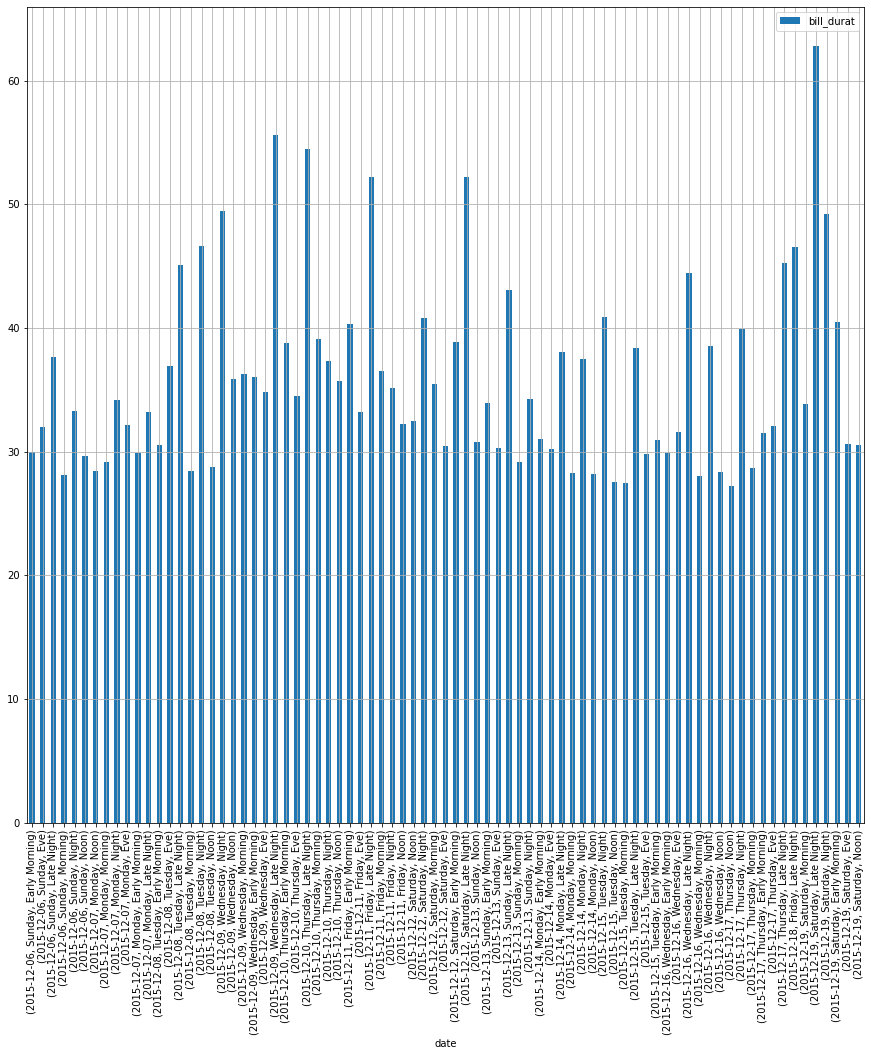

In [571]:
client_day_bill.plot(x='date',  y='bill_durat', rot=90, kind='bar', figsize=(15, 15),
                    grid=True)
plt.show()